# Human _vs._ Rat

Correlations.

In [1]:
from sqlalchemy import create_engine

from math import ceil

from collections import OrderedDict as odict

from itertools import product, chain

cfi = chain.from_iterable

import json

import seaborn as sns

sns.set()

import textwrap

In [2]:
# ChEMBL connection...

engine = create_engine(open('database.txt').read().strip())

In [3]:
# pActivity column to use...

pactivity_col = 'pchembl_value'

In [4]:
# Outcomes...

outcomes = {(True, True): 'TP', (True, False): 'FP', (False, True): 'FN', (False, False): 'TN'}

In [5]:
# Minimum number of compounds in common for a pair of targets...

pair_threshold = 3

### Load targets

In [6]:
targets = pd.read_pickle('chembl_targets.pkl').query('exclude == 0').drop('exclude', axis=1)

targets.shape

(358, 14)

In [7]:
def f(group):
    
    record = {}
    
    for species in ['Human', 'Rat']:
        
        targets = group.query("species == @species")[['pref_name', 'target_type', 'chembl_id']].values.tolist()
        
        targets = tuple(tuple(x) for x in targets) if targets else ''
        
        record[species + '_targets'] = targets
        
        record[species + '_N'] = len(targets)
    
    return pd.Series(record)

targets = targets.groupby('symbol').apply(f)

targets.shape

(192, 4)

In [8]:
# Symbols with ChEMBL targets for both species...

targets = targets.query("Human_N > 0 and Rat_N > 0")

targets.shape

(116, 4)

In [9]:
targets.head()

,Human_N,Human_targets,Rat_N,Rat_targets
symbol,,,,
ABCB1,1,"((P-glycoprotein 1, SINGLE PROTEIN, CHEMBL4302),)",1,"((Multidrug resistance protein 1, SINGLE PROTEIN, CHEMBL1075229),)"
ABCB11,1,"((Bile salt export pump, SINGLE PROTEIN, CHEMBL6020),)",1,"((Bile salt export pump, SINGLE PROTEIN, CHEMBL2073674),)"
ABCB4,1,"((Multidrug resistance protein 3, SINGLE PROTEIN, CHEMBL1743129),)",1,"((Multidrug resistance protein 3, SINGLE PROTEIN, CHEMBL2073706),)"
ABCC2,1,"((Canalicular multispecific organic anion transporter 1, SINGLE PROTEIN, CHEMBL5748),)",1,"((Canalicular multispecific organic anion transporter 1, SINGLE PROTEIN, CHEMBL2073676),)"
ABCC3,1,"((Canalicular multispecific organic anion transporter 2, SINGLE PROTEIN, CHEMBL5918),)",1,"((Canalicular multispecific organic anion transporter 2, SINGLE PROTEIN, CHEMBL2073682),)"


### Get data for targets

In [10]:
target_chemblids = [x[2] for x in cfi(targets[['Human_targets', 'Rat_targets']].stack().unique())]

data = pd.read_sql_query("""
        select
            *
        from
            tt_curve_data_v1
        where
            target_chemblid in ({})
        and
            exclude = 0
    """.format(','.join(":{}".format(n+1) for n in range(len(target_chemblids)))), engine, params=target_chemblids)

data.set_index('target_chemblid', drop=False, inplace=True)

data.shape

(225462, 32)

In [11]:
# Mean data by symbol/species/compound...

means = data[['symbol', 'species', 'parent_cmpd_chemblid', pactivity_col]].groupby(['symbol', 'species', 'parent_cmpd_chemblid']).mean()

means.shape

(172398, 1)

In [12]:
HTML(means.head().to_html())

In [13]:
means = means.unstack(level=[0, 1])

means.columns = means.columns.droplevel()

means.shape

(120092, 205)

In [14]:
means[~means.ix[:,:10].isnull().all(axis=1)].head()

symbol               ABCB1 ABCB11     ABCC2     ABCC3     ABCC4   ACE     ... SLCO2B1     TBXA2R        TH     UTS2R       VDR    
species              Human  Human Rat Human Rat Human Rat Human Human Rat ...   Human Rat  Human Rat Human Rat Human Rat Human Rat
parent_cmpd_chemblid                                                      ...                                                     
CHEMBL1               6.38    NaN NaN   NaN NaN   NaN NaN   NaN   NaN NaN ...     NaN NaN    NaN NaN   NaN NaN   NaN NaN   NaN NaN
CHEMBL100063           NaN    NaN NaN   NaN NaN   NaN NaN   NaN  8.62 NaN ...     NaN NaN    NaN NaN   NaN NaN   NaN NaN   NaN NaN
CHEMBL100413           NaN    NaN NaN   NaN NaN   NaN NaN   NaN  8.77 NaN ...     NaN NaN    NaN NaN   NaN NaN   NaN NaN   NaN NaN
CHEMBL100586           NaN    NaN NaN   NaN NaN   NaN NaN   NaN  5.62 NaN ...     NaN NaN    NaN NaN   NaN NaN   NaN NaN   NaN NaN
CHEMBL100826           NaN    NaN NaN   NaN NaN   NaN NaN   NaN  8.64 NaN ...     NaN NaN    NaN NaN   NaN NaN   NaN NaN   NaN NaN

[5 rows x 205 columns]

In [15]:
means.ix[:,:10][~means.ix[:,:10].isnull().all(axis=1)].head()

symbol               ABCB1 ABCB11     ABCC2     ABCC3     ABCC4   ACE    
species              Human  Human Rat Human Rat Human Rat Human Human Rat
parent_cmpd_chemblid                                                     
CHEMBL1               6.38    NaN NaN   NaN NaN   NaN NaN   NaN   NaN NaN
CHEMBL100063           NaN    NaN NaN   NaN NaN   NaN NaN   NaN  8.62 NaN
CHEMBL100413           NaN    NaN NaN   NaN NaN   NaN NaN   NaN  8.77 NaN
CHEMBL100586           NaN    NaN NaN   NaN NaN   NaN NaN   NaN  5.62 NaN
CHEMBL100826           NaN    NaN NaN   NaN NaN   NaN NaN   NaN  8.64 NaN

### Symbols with sufficient pairs of compounds in common to allow a comparison

In [16]:
def f(x):
    
    df = means[x].dropna(how='any')
        
    if not (df.shape[1] == 2 and df.shape[0] >= pair_threshold):
        
        logging.warn("{} not OK ({} cols, {} rows)".format(x, df.shape[1], df.shape[0]))
        
        return None
    
    logging.info("{} OK ({} cols, {} rows)".format(x, df.shape[1], df.shape[0]))
    
    df['outcome'] = (df > 5.0).apply(lambda x: outcomes[tuple(x[['Rat', 'Human']])], axis=1) # For checking predictivity of Rat activity for Human (see below)
    
    return (x, df)
    
means_by_symbol = odict(y for y in (f(x) for x in means.columns.levels[0]) if y)

[2015/Aug/12 13:04:22 WARNING ] ABCB1 not OK (1 cols, 1046 rows)
[2015/Aug/12 13:04:22 INFO    ] ABCB11 OK (2 cols, 3 rows)
[2015/Aug/12 13:04:22 INFO    ] ABCC2 OK (2 cols, 5 rows)
[2015/Aug/12 13:04:22 WARNING ] ABCC3 not OK (2 cols, 0 rows)
[2015/Aug/12 13:04:22 WARNING ] ABCC4 not OK (1 cols, 19 rows)
[2015/Aug/12 13:04:22 INFO    ] ACE OK (2 cols, 18 rows)
[2015/Aug/12 13:04:22 INFO    ] ACHE OK (2 cols, 233 rows)
[2015/Aug/12 13:04:23 WARNING ] ADCY5 not OK (2 cols, 0 rows)
[2015/Aug/12 13:04:23 INFO    ] ADORA1 OK (2 cols, 224 rows)
[2015/Aug/12 13:04:23 INFO    ] ADORA2A OK (2 cols, 310 rows)
[2015/Aug/12 13:04:23 INFO    ] ADORA2B OK (2 cols, 29 rows)
[2015/Aug/12 13:04:23 INFO    ] ADORA3 OK (2 cols, 117 rows)
[2015/Aug/12 13:04:23 INFO    ] ADRA1A OK (2 cols, 91 rows)
[2015/Aug/12 13:04:23 INFO    ] ADRA1B OK (2 cols, 48 rows)
[2015/Aug/12 13:04:23 INFO    ] ADRA1D OK (2 cols, 113 rows)
[2015/Aug/12 13:04:23 INFO    ] ADRA2A OK (2 cols, 18 rows)
[2015/Aug/12 13:04:23 INFO   

In [17]:
len(means_by_symbol)

72

In [25]:
# Correlation coefficients...

corr = pd.DataFrame(({'symbol': symbol, 'N': df.shape[0], 'r': df.corr(method='pearson').iloc[0, 1]} for (symbol, df) in means_by_symbol.iteritems()), columns=['symbol', 'N', 'r']).set_index('symbol')

corr.query("N > 10").sort('r', ascending=False)

,N,r
symbol,,
ESR1,18,0.975634
CHRM4,16,0.953765
ADORA2B,29,0.953139
AVPR1B,25,0.930529
CHRM3,22,0.926929
EDNRA,114,0.908507
ESR2,23,0.907347
CALCRL,11,0.906617
HTR4,13,0.905589


In [19]:
corr.to_pickle('human_vs_rat_corr.pkl')

### Plot correlations

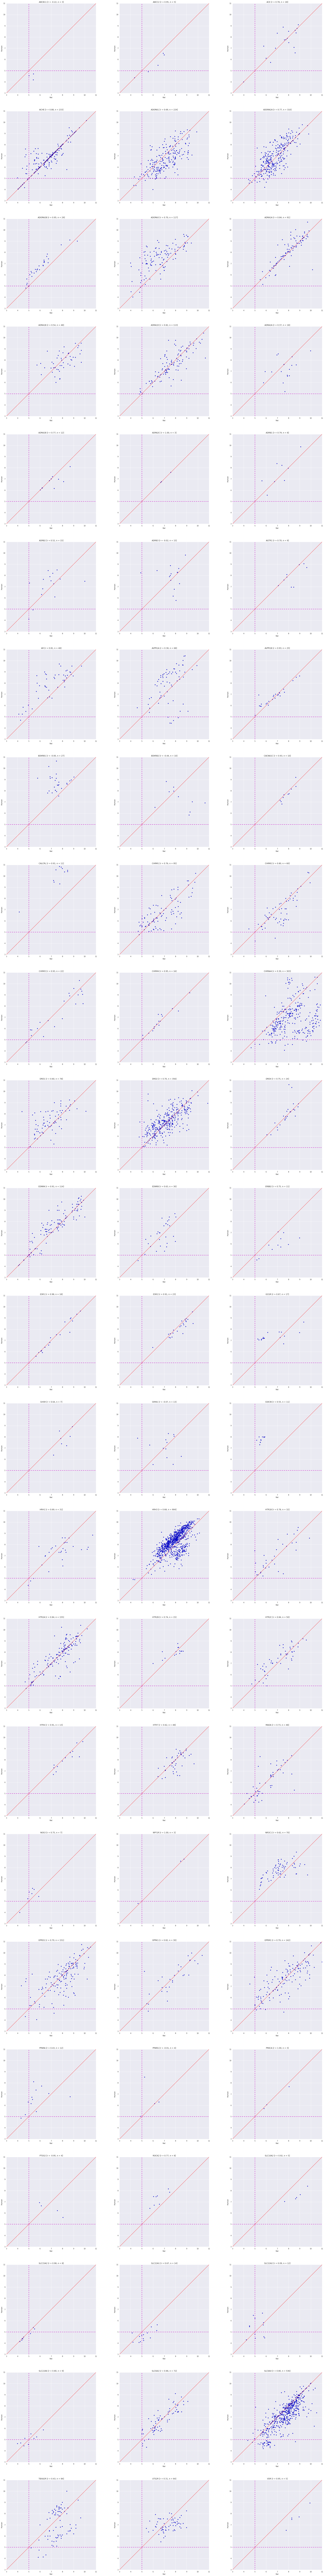

In [20]:
ncol, size = 3, 12

min_xc50, max_xc50 = 3.0, 11.0

n_symbols = len(means_by_symbol)

nrow = int(ceil(n_symbols / ncol))

fig, axes = plt.subplots(nrow, ncol, figsize=(size*ncol, size*nrow))

if nrow > 1: axes = list(cfi(axes))
    
for i, (symbol, df) in enumerate(means_by_symbol.iteritems()):
        
    axis = axes[i]
    
    axis.scatter(x=df['Rat'], y=df['Human'])
    
    axis.set_xlim(min_xc50, max_xc50)
    axis.set_ylim(min_xc50, max_xc50)
    axis.set_aspect(1)

    axis.set_title("{} [r = {:.2f}, n = {:d}]".format(symbol, corr['r'][symbol], df.shape[0]))
    axis.set_xlabel("{}".format('Rat'))
    axis.set_ylabel("{}".format('Human'))

    
    axis.plot((min_xc50, max_xc50), (min_xc50, max_xc50), color='r', linestyle='-', linewidth=1)
    axis.plot((5, 5), (min_xc50, max_xc50), color='m', linestyle='--', linewidth=2)
    axis.plot((min_xc50, max_xc50), (5, 5), color='m', linestyle='--', linewidth=2)

### Predictivity of Rat activity for Human

In [21]:
def f(symbol, df):
    
    outcomes = dict(df['outcome'].value_counts())

    TP, FP, FN, TN = [outcomes[x] if x in outcomes else 0 for x in ['TP', 'FN', 'FP', 'TN']]

    ACC = (TP + TN) / (TP + FP + FN + TN)

    F1 = 2 * TP / (2 * TP + FP + FN)

    # MCC = (TP * TN - FP * FN)/sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    
    return {'symbol': symbol, 'N': df.shape[0], 'ACC': round(ACC, 2), 'F1': round(F1, 2) }

scores = pd.DataFrame([f(symbol, df) for symbol, df in means_by_symbol.items()], columns=['symbol', 'N', 'ACC', 'F1']).set_index('symbol')

In [22]:
scores.sort('ACC', ascending=False)

,N,ACC,F1
symbol,,,
ESR1,18,1.00,1.00
BDKRB2,10,1.00,1.00
CHRM3,22,1.00,1.00
CHRM4,16,1.00,1.00
DRD4,24,1.00,1.00
EDNRB,30,1.00,1.00
ESR2,23,1.00,1.00
GCGR,17,1.00,1.00
GHSR,7,1.00,1.00


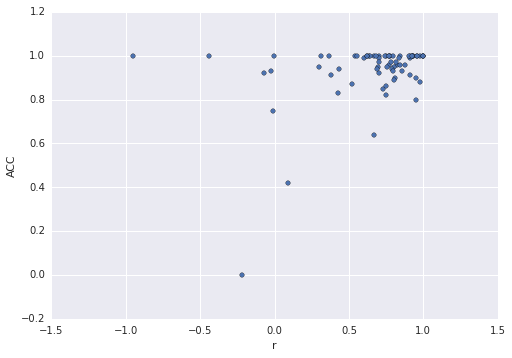

In [23]:
# Compare with correlation coefficients...

corr.merge(scores.drop('N', axis=1), left_index=True, right_index=True).plot(x='r', y='ACC', kind='scatter')